In [3]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import astropy.units as u
import astropy.constants as c
from scipy import interpolate
from tqdm import tqdm

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

sys.path.append(os.environ['DH_DIR'])
import darkhistory.physics as dhphys

sys.path.append(os.environ['DM21CM_DIR'])
from dm21cm.precompute.accretion import *
from dm21cm.utils import load_h5_dict

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../../matplotlibrc')

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion


# Test build table

In [24]:
M_s = jnp.array([1e0, 1e1, 1e2, 1e3, 1e4]) # [M_sun]
z_s = jnp.geomspace(4, 3000, 5)
r_s = jnp.geomspace(1e-5, 1e20, 100) # [km]
veff_s = jnp.geomspace(1e0, 1e8, 100) # [km/s]

In [ ]:
v_s

In [25]:
table_Mzv = np.zeros((len(M_s), len(z_s), len(veff_s)))
for i_M, M in enumerate(tqdm(M_s)):
    for i_z, z in enumerate(z_s):
        v_s = veff_HALO(z=z, M=M, rBeff=r_s)
        interp = interpolate.interp1d(v_s, r_s, bounds_error=False, fill_value='extrapolate')
        table_Mzv[i_M, i_z] = interp(veff_s)

100%|██████████| 5/5 [00:00<00:00, 166.09it/s]


/tmp/ipykernel_3620207/1954528927.py:16: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set(xscale='log', yscale='log')


[Text(0.5, 0, 'r [km]'), Text(0, 0.5, 'v_eff [km/s]')]

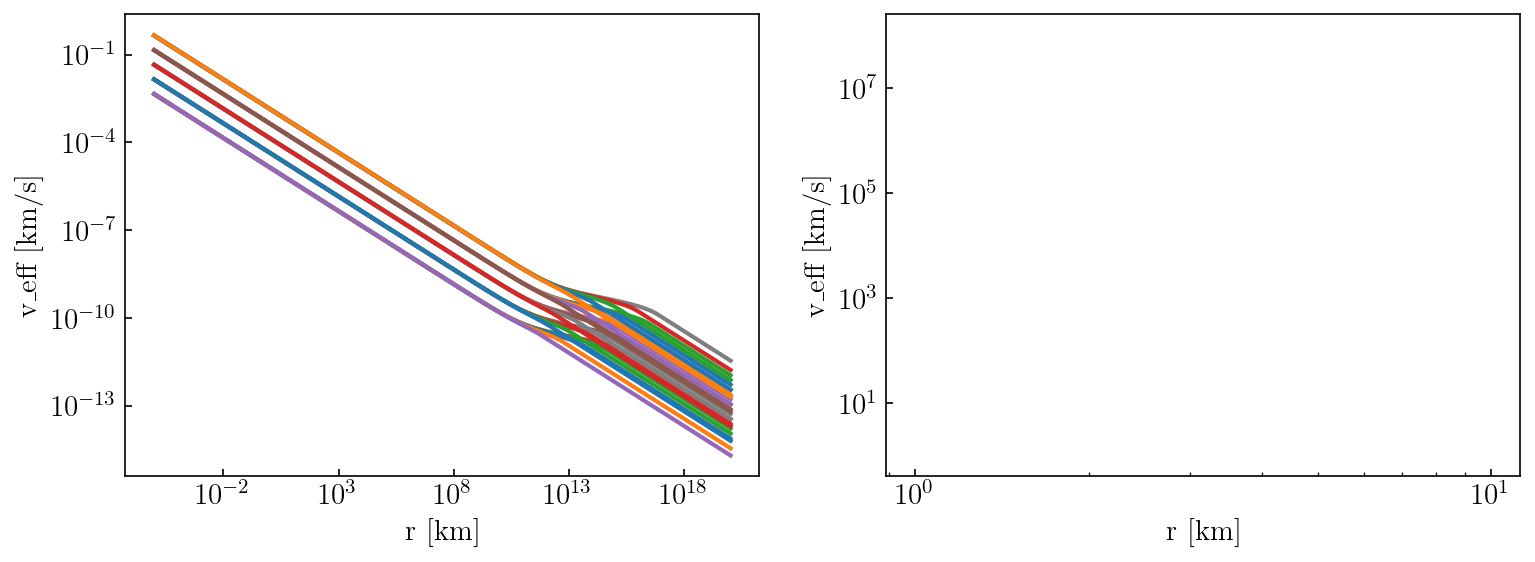

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
for M in M_s:
    for z in z_s:
        v_s = veff_HALO(z=z, M=M, rBeff=r_s)
        ax.plot(r_s, v_s, label=f'M={M:.1e}, z={z:.1e}')
ax.set(xscale='log', yscale='log')
# ax.set(xlim=(1e-5, 1e20), ylim=(1e0, 1e8))
ax.set(xlabel='r [km]', ylabel='v_eff [km/s]')

ax = axs[1]
for i_M, M in enumerate(M_s):
    for i_z, z in enumerate(z_s):
        ax.plot(table_Mzv[i_M, i_z], veff_s)
ax.set(xscale='log', yscale='log')
# ax.set(xlim=(1e-5, 1e20), ylim=(1e0, 1e8))
ax.set(xlabel='r [km]', ylabel='v_eff [km/s]')

[Text(0.5, 0, 'r [km]'), Text(0, 0.5, 'v_eff [km/s]')]

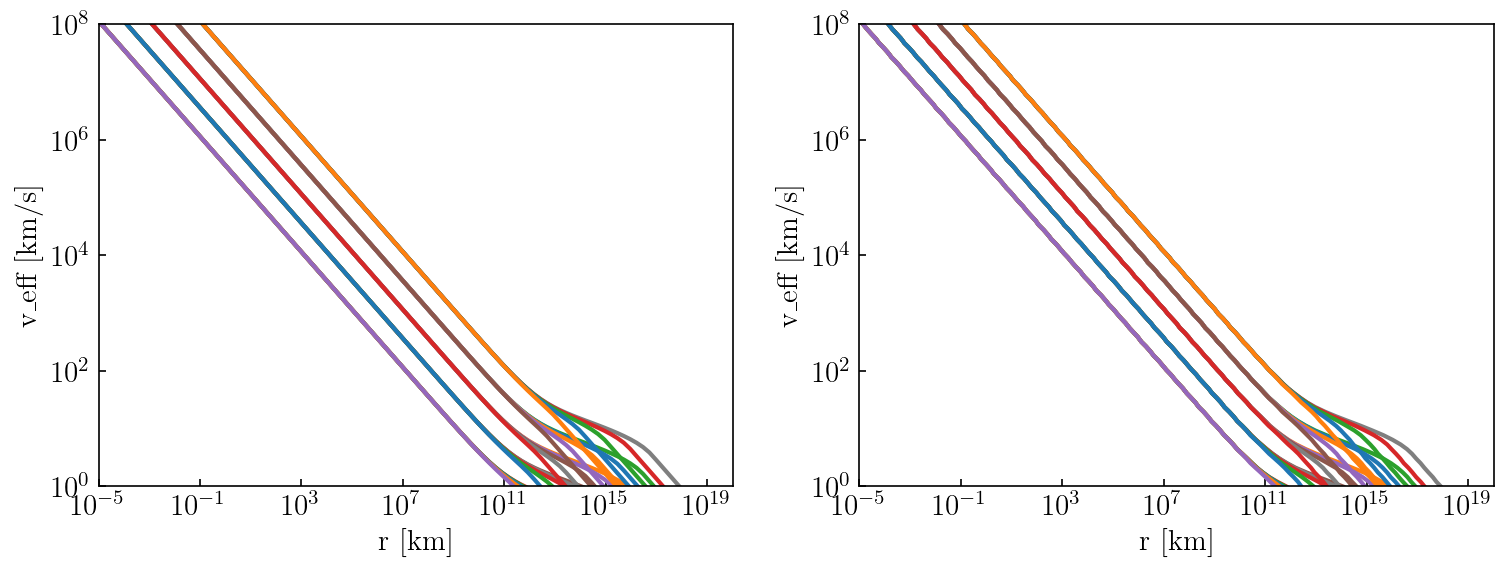

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
for M in M_s:
    for z in z_s:
        v_s = veff_HALO(z=z, M=M, rBeff=r_s)
        ax.plot(r_s, v_s, label=f'M={M:.1e}, z={z:.1e}')
ax.set(xscale='log', yscale='log')
ax.set(xlim=(1e-5, 1e20), ylim=(1e0, 1e8))
ax.set(xlabel='r [km]', ylabel='v_eff [km/s]')

ax = axs[1]
for i_M, M in enumerate(M_s):
    for i_z, z in enumerate(z_s):
        ax.plot(table_Mzv[i_M, i_z], veff_s)
ax.set(xscale='log', yscale='log')
ax.set(xlim=(1e-5, 1e20), ylim=(1e0, 1e8))
ax.set(xlabel='r [km]', ylabel='v_eff [km/s]')

# Build production table
See ../build_rBeff_tables.py

In [22]:
! du -smh ../../data/pbh-accretion/*

32K	../../data/pbh-accretion/delta0.001.txt
32K	../../data/pbh-accretion/delta0.010.txt
32K	../../data/pbh-accretion/delta0.100.txt
32K	../../data/pbh-accretion/delta0.500.txt
32K	../../data/pbh-accretion/epsilon.json
172M	../../data/pbh-accretion/L_table_cache
4.0M	../../data/pbh-accretion/rBeff_mzv.h5


In [11]:
d = load_h5_dict('../../data/pbh-accretion/rBeff_mzv.h5')
np.any(np.isnan(d['table']))

False

# $M_\text{halo}/M_\text{no\,halo}$ (fig 3 of 2403.18895)

In [13]:
M_s = [1e1, 1e2, 1e3, 1e4]
ratio_s = []

for M in M_s:
    M_PR_s = []
    M_PRHALO_s = []
    z_s = np.geomspace(10-1, 1000, 100)

    for z in tqdm(z_s):
        v = v_cb_cosmo(z)
        rho_inf = (cosmo.critical_density(z) * cosmo.Ob(z)).to(u.g/u.cm**3).value # [g/cm^3]
        c_in = 23

        T_k = dhphys.Tm_std(1+z) # [eV]
        x_e = dhphys.xHII_std(1+z)
        c_inf = np.sqrt(5/3 * (1+x_e) * T_k * u.eV / c.m_p).to(u.km/u.s).value

        M_PR_s.append(Mdot_PR(M, rho_inf, v, c_in, c_inf, lambda_fudge=1, z=z))
        M_PRHALO_s.append(Mdot_PRHALO(M, rho_inf, v, c_in, c_inf, lambda_fudge=1, z=z))

    M_PR_s = np.array(M_PR_s)
    M_PRHALO_s = np.array(M_PRHALO_s)
    ratio_s.append(M_PRHALO_s / M_PR_s)

100%|██████████| 100/100 [00:04<00:00, 21.84it/s]


In [ ]:
ratio_s[2]

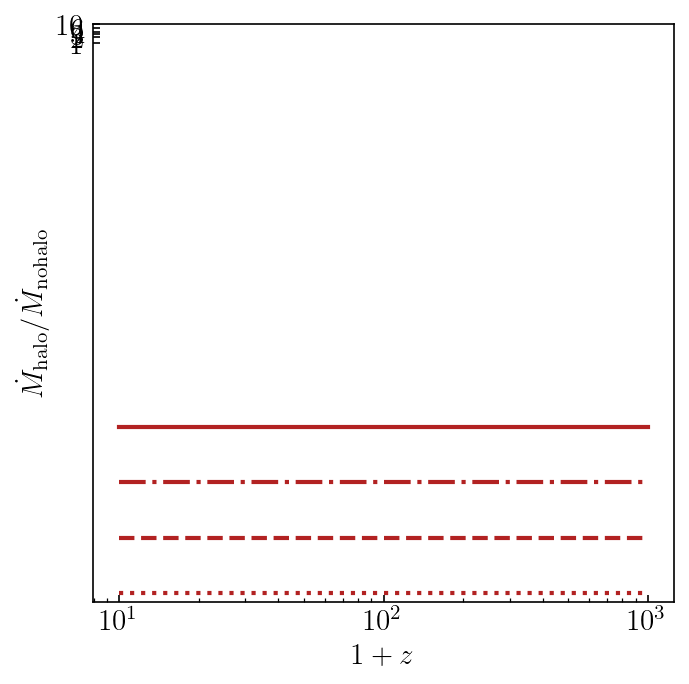

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ls_s = ['-', '-.', '--', ':']
for i, ratio in enumerate(ratio_s):
    ax.plot(1+z_s, ratio, ls=ls_s[i], color='firebrick')
ax.set(xscale='log', yscale='log')
# ax.set(xlim=(1e1, 1e3), ylim=(1e-6, 10))
ax.set(yticks=[1, 2, 3, 4, 6, 10], yticklabels=[1, 2, 3, 4, 6, 10])
ax.set(xlabel=r'$1+z$', ylabel=r'$\dot{M}_{\rm halo} / \dot{M}_{\rm no halo}$');